In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


In [10]:
df = pd.read_csv("Creditcard_data.csv")

print("Dataset Shape:", df.shape)
print("\nClass Distribution:")
print(df["Class"].value_counts())


Dataset Shape: (772, 31)

Class Distribution:
Class
0    763
1      9
Name: count, dtype: int64


In [11]:
df_class0 = df[df["Class"] == 0]
df_class1 = df[df["Class"] == 1]

df_class1_oversampled = df_class1.sample(
    n=len(df_class0),
    replace=True,
    random_state=42
)

df_balanced = pd.concat([df_class0, df_class1_oversampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced Dataset Shape:", df_balanced.shape)
print("\nBalanced Class Distribution:")
print(df_balanced["Class"].value_counts())


Balanced Dataset Shape: (1526, 31)

Balanced Class Distribution:
Class
1    763
0    763
Name: count, dtype: int64


In [12]:
sample1 = df_balanced.sample(frac=0.7, random_state=1)


In [13]:
k = int(len(df_balanced) / (0.7 * len(df_balanced)))
sample2 = df_balanced.iloc[::k, :]


In [14]:
sample3_class0 = df_balanced[df_balanced["Class"] == 0].sample(frac=0.7, random_state=1)
sample3_class1 = df_balanced[df_balanced["Class"] == 1].sample(frac=0.7, random_state=1)

sample3 = pd.concat([sample3_class0, sample3_class1])


In [15]:
df_balanced["Cluster"] = pd.qcut(df_balanced["Amount"], 5, labels=False)

selected_clusters = np.random.choice(
    df_balanced["Cluster"].unique(),
    size=3,
    replace=False
)

sample4 = df_balanced[df_balanced["Cluster"].isin(selected_clusters)]


In [16]:
sample5 = df_balanced.head(int(0.7 * len(df_balanced)))


## Model Training and Evaluation


In [17]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC()
}


In [18]:
def evaluate_sample(sample):
    X = sample.drop(["Class", "Cluster"], axis=1, errors="ignore")
    y = sample["Class"]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    results = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        results[name] = round(acc, 4)
        
    return results


In [19]:
results_table = pd.DataFrame()

results_table["Simple Random"] = pd.Series(evaluate_sample(sample1))
results_table["Systematic"] = pd.Series(evaluate_sample(sample2))
results_table["Stratified"] = pd.Series(evaluate_sample(sample3))
results_table["Cluster"] = pd.Series(evaluate_sample(sample4))
results_table["Convenience"] = pd.Series(evaluate_sample(sample5))

results_table


,Simple Random,Systematic,Stratified,Cluster,Convenience
Logistic Regression,0.9564,0.8974,0.9128,0.9203,0.9346
Decision Tree,0.9969,0.9956,0.9938,0.9891,0.9875
Random Forest,1.0000,1.0000,1.0000,0.9964,1.0000
KNN,0.9813,0.9869,0.9595,0.9601,0.9751
SVM,0.6885,0.7118,0.7196,0.7029,0.7103


In [20]:
print("Best Sampling Technique per Model:\n")

for model in results_table.index:
    best_sampling = results_table.loc[model].idxmax()
    best_accuracy = results_table.loc[model].max()
    
    print(f"{model:20s} -> {best_sampling} ({best_accuracy:.4f})")


print("\nBest Model per Sampling Technique:\n")

for col in results_table.columns:
    best_model = results_table[col].idxmax()
    best_accuracy = results_table[col].max()
    
    print(f"{col:15s} -> {best_model} ({best_accuracy:.4f})")


Best Sampling Technique per Model:

Logistic Regression  -> Simple Random (0.9564)
Decision Tree        -> Simple Random (0.9969)
Random Forest        -> Simple Random (1.0000)
KNN                  -> Systematic (0.9869)
SVM                  -> Stratified (0.7196)

Best Model per Sampling Technique:

Simple Random   -> Random Forest (1.0000)
Systematic      -> Random Forest (1.0000)
Stratified      -> Random Forest (1.0000)
Cluster         -> Random Forest (0.9964)
Convenience     -> Random Forest (1.0000)


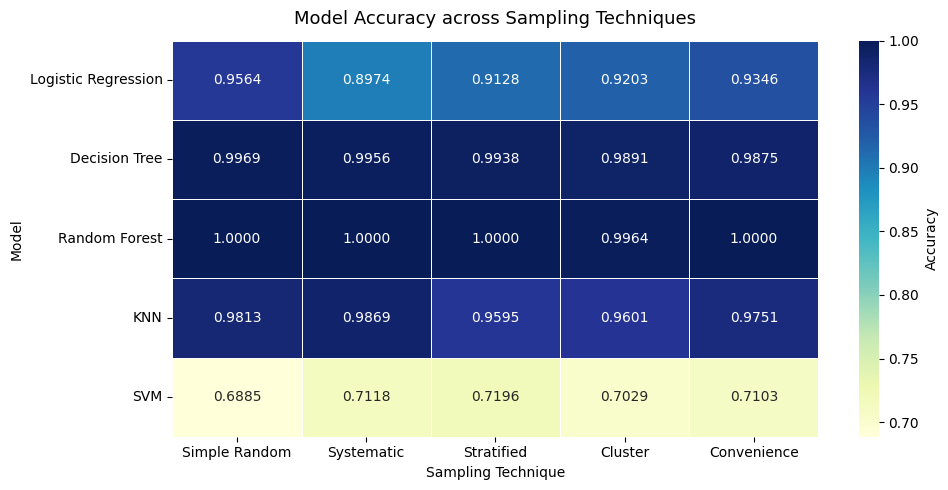

In [26]:
plt.figure(figsize=(10, 5))

sns.heatmap(
    results_table.astype(float),
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={"label": "Accuracy"}
)

plt.title("Model Accuracy across Sampling Techniques", fontsize=13, pad=12)
plt.xlabel("Sampling Technique")
plt.ylabel("Model")

plt.tight_layout()
plt.savefig("plots/sampling_heatmap.png", dpi=150)
plt.show()
